In [5]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
import calfem.vis_mpl as cfvl

import numpy as np
from numba import njit

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import time


#For FEM
def reshape_boundary_dict(bdofs):
    nodeset = set([0])
    for array in bdofs.items():
        nodeset.update(array[1])
    new = np.zeros(len(nodeset)-1)
    for key in bdofs:
        for elem in bdofs[key]:
            new[elem-1] = key
    return new

<h3> Functions for analyzing FEM solutions

In [6]:


export_path = "./latex/illustr/domain_rectangle_dirichlet_only/"
# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements, linewidth: float = 0.2):
    # print(nodes_x)
    it = 0
    for element in elements:
        x = [nodes_x[element[0]], nodes_x[element[1]], nodes_x[element[2]]]
        y = [nodes_y[element[0]], nodes_y[element[1]], nodes_y[element[2]]]
        # print(x , y)
        plt.fill(x, y, edgecolor='black', linewidth = linewidth, fill=False)
        it += 1

@njit()
def mean_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1]][0] - coords[poly[0]][0]) * (coords[poly[2]][1] - coords[poly[0]][1]) - (coords[poly[2]][0] - coords[poly[0]][0]) * (coords[poly[1]][1] - coords[poly[0]][1])) / 2
    res = 0.
    for el in polygons:
        res += S_el(el)
    return round(res / len(polygons), 8)

@njit()
def max_square(coords, polygons):
    
    S_el = lambda poly: ((coords[poly[1]][0] - coords[poly[0]][0]) * (coords[poly[2]][1] - coords[poly[0]][1]) - (coords[poly[2]][0] - coords[poly[0]][0]) * (coords[poly[1]][1] - coords[poly[0]][1])) / 2
    S_max = 0.
    tmp = 0.
    for el in polygons:
        tmp = S_el(el)
        if (tmp > S_max):
            S_max = tmp
    return round(S_max, 8)

@njit()
def exact_solution(x, y, row_num_el: int = 350):
    res = 0
    for n in range(1, row_num_el + 1):
        if n % 2 != 0:
            res += 20 * (1 - (-1) ** n) / (np.pi * n) / (np.exp(- np.pi * n / 2 ) - np.exp( np.pi * n / 2 )) * (np.exp(- np.pi * n / 4 * (2 - y) ) - np.exp( np.pi * n / 4 * (2 - y))) * np.sin(np.pi * n / 4 * x)
    if np.fabs(res) < 1e-15:
        return 0.
    return res


def print_error(x, y, z):
    error_in_node = [];
    for i in range(len(z)):
        error_in_node.append( np.fabs( z[i] - exact_solution(x[i], y[i]) ))

    mean_err = round(np.mean(error_in_node), 4)
    print("Mean error: ", mean_err)

    ind_max = np.argmax(error_in_node)
    print("Max error: ", round(np.max(error_in_node), 4),  f"point: ({round(x[ind_max], 4)}, {round(y[ind_max], 4)})" )
    
    nodes_with_high_err = np.where(error_in_node > mean_err * 1.25)[0]
    # print(nodes_with_high_err)
    coords_with_high_err = []
    
    for j in nodes_with_high_err:
        coords_with_high_err.append([x[j], y[j]])
    coords_with_high_err = np.array(coords_with_high_err).T
    # print(coords_with_high_err)
    return coords_with_high_err

    # for i in range(len(error_in_node)):
    #     if error_in_node[i] > 0.2:
    #         print( x[i], y[i], error_in_node[i])



def print_mean_rel_error(x, y ,z):
    error_in_node = [];
    for i in range(len(z)):
        z_exact = exact_solution(x[i], y[i])
        if np.fabs(z_exact) > 1e-9:
            error_in_node.append( np.divide(np.fabs( z[i] - z_exact ) , z_exact) )
    print("Mean rel error: ", round(np.mean(error_in_node), 8))




@njit
def L2_error_njit(coords, polygons, solution):
    res = 0.

    S_el = lambda poly: ((coords[poly[1]][0] - coords[poly[0]][0]) * (coords[poly[2]][1] - coords[poly[0]][1]) - (coords[poly[2]][0] - coords[poly[0]][0]) * (coords[poly[1]][1] - coords[poly[0]][1])) / 2
    error_in_node = [];
    for poly in polygons:
        Si = S_el(poly)    
        tmp = 0.
        for j in range(3):
            tmp += (exact_solution(coords[poly[j]][0], coords[poly[j]][1]) - solution[poly[j]]) ** 2
        res += Si * tmp / 3
        # res += tmp / 3

    return res

def L2_error(coords, polygons, solution):
    res = L2_error_njit(coords, polygons, solution)
    print(f"L2_error S: {round(res, 8)}")
    pass



### Define Geometry

Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmp_07s3k71/tempGeometry.geo'...
Info    : Done reading '/tmp/tmp_07s3k71/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.0193229s, CPU 0.01932s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 0.466654s, CPU 0.466465s)
Info    : 16352 nodes 32587 elements
Info    : Writing '/tmp/tmp_07s3k71/meshFile.msh'...
Info    : Done writing '/tmp/tmp_07s3k71/meshFile.msh'
mean:  0.0008853
max:  11.28299525
[ 0.  0.  0.  0. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80.

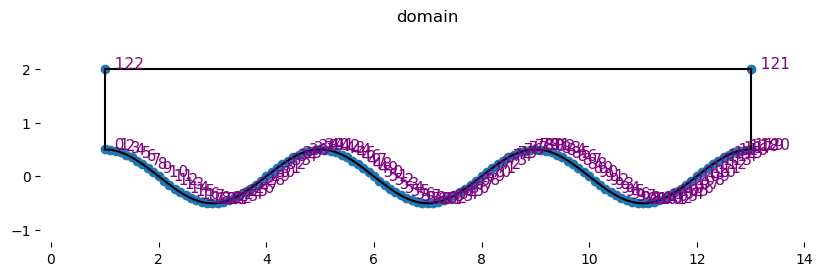

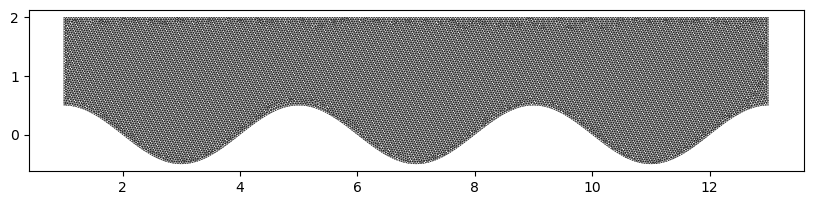

In [7]:
g = cfg.Geometry()

p_coords = []

h = 0.1
x = 1.
ind = []


while x <= 13:
    ind.append(len(p_coords))
    p_coords.append([round(x, 2), 1 / 2 * np.sin( np.pi / 2 * round(x, 2))])
    x = round(x + h, 2)
    # print([p_coords[-1], len(p_coords) - 1])
    g.point(p_coords[-1], len(p_coords) - 1)

g.spline(ind.copy(), 0)

# print(ind)

g.point([13., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)


g.spline([ind[-2], ind[-1]] , 1)


g.point([1., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)

g.spline([ind[-2], ind[-1]] , 2)


g.spline([ind[-1], 0] , 3)


g.surface([0, 1, 2, 3])

for curveID in [0]:
    g.curveMarker(curveID, 80)


cfvl.figure(fig_size=(10,5))
cfvl.draw_geometry(
        g,
        
        label_curves=False,
        title="domain"
)


mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.042 # Element size Factor 
"""
    mesh.elSizeFactor = 0.3325  ~   max S_el = 0.05
    mesh.elSizeFactor = 0.1425  ~   max S_el = 0.01
    mesh.elSizeFactor = 0.042   ~   max S_el = 0.001
    0.029 ~ 0.0005
"""
coords, edof, dofs, bdofs, elementmarkers = mesh.create()

print("mean: ", mean_square(coords, edof))
print("max: ", max_square(coords, edof))
boundary_voltages = reshape_boundary_dict(bdofs)
print(boundary_voltages)

cfvl.figure(fig_size=(10,5))
cfvl.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=False,
    #title="Example 2 - Mesh"
)
#plot_fem_mesh(coords, edof)


<h3> Refactoring mesh structere for C++

In [41]:
# # for i in reversed(range(44, 51)):
# #     print(f"""{2.0}, {coords[i][1]}""")

# for i in reversed(range(242, 277)):
#     # print(f"""{round(coords[i][0],2)}, {round(coords[i][1],2)}""")
#     print(f"""5.0, {round(coords[i][1],2)}""")

# # print(f"""x,y""")
# # for i in coords:
# #     print(f"""{i[0]}, {i[1]}""")

In [40]:
# print(f"""p1,p2,p3""")
# for i in edof:
#     print(f"""{i[0]}, {i[1]}, {i[2]}""")

Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmp4syknv86/tempGeometry.geo'...
Info    : Done reading '/tmp/tmp4syknv86/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.0162884s, CPU 0.013765s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 0.43828s, CPU 0.435857s)
Info    : 16352 nodes 32587 elements
Info    : Writing '/tmp/tmp4syknv86/meshFile.msh'...
Info    : Done writing '/tmp/tmp4syknv86/meshFile.msh'
mean:  0.0008853
max:  11.28299525
[ 0.  0.  0.  0. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 

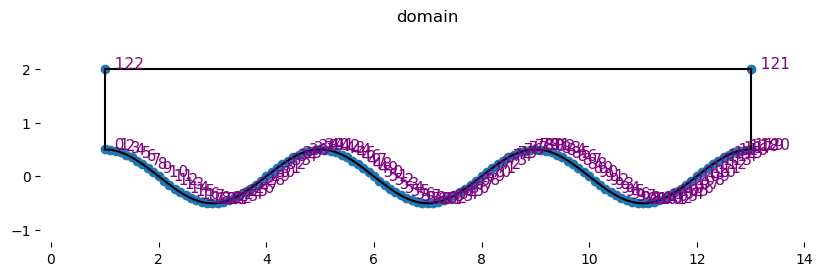

In [10]:
g = cfg.Geometry()

p_coords = []

h = 0.1
x = 1.
ind = []


while x <= 13:
    ind.append(len(p_coords))
    p_coords.append([round(x, 2), 1 / 2 * np.sin( np.pi / 2 * round(x, 2))])
    x = round(x + h, 2)
    # print([p_coords[-1], len(p_coords) - 1])
    g.point(p_coords[-1], len(p_coords) - 1)

g.spline(ind.copy(), 0)

# print(ind)

g.point([13., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)


g.spline([ind[-2], ind[-1]] , 1)


g.point([1., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)

g.spline([ind[-2], ind[-1]] , 2)


g.spline([ind[-1], 0] , 3)


g.surface([0, 1, 2, 3])

for curveID in [0]:
    g.curveMarker(curveID, 80)


cfvl.figure(fig_size=(10,5))
cfvl.draw_geometry(
        g,
        
        label_curves=False,
        title="domain"
)


mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.042 # Element size Factor 
"""
    mesh.elSizeFactor = 0.3325  ~   max S_el = 0.05
    mesh.elSizeFactor = 0.1425  ~   max S_el = 0.01
    mesh.elSizeFactor = 0.042   ~   max S_el = 0.001
    0.029 ~ 0.0005
"""
coords, edof, dofs, bdofs, elementmarkers = mesh.create()

print("mean: ", mean_square(coords, edof))
print("max: ", max_square(coords, edof))
boundary_voltages = reshape_boundary_dict(bdofs)
print(boundary_voltages)

# cfvl.figure(fig_size=(10,5))
# cfvl.draw_mesh(
#     coords=coords,
#     edof=edof,
#     dofs_per_node=mesh.dofs_per_node,
#     el_type=mesh.el_type,
#     filled=False,
#     #title="Example 2 - Mesh"
# )
# #plot_fem_mesh(coords, edof)


<h3> Refactoring mesh structere for C++

In [39]:
# # for i in reversed(range(44, 51)):
# #     print(f"""{2.0}, {coords[i][1]}""")

# for i in reversed(range(649, 685)):
#     # print(f"""{round(coords[i][0],2)}, {round(coords[i][1],2)}""")
#     print(f"""13.0, {round(coords[i][1],2)}""")

# # print(f"""x,y""")
# # for i in coords:
# #     print(f"""{i[0]}, {i[1]}""")

In [38]:
# print(f"""p1,p2,p3""")
# for i in edof:
#     print(f"""{i[0]}, {i[1]}, {i[2]}""")

<h3> Rectangle domain

In [13]:
# g = cfg.Geometry()

# g.point([0.0, 1.0]) # point 0
# g.point([1.0, 0.0]) # point 1
# g.point([2.0, 1.0]) # point 2

# g.point([2.0, 2.0]) # point 3
# g.point([0.0, 2.0]) # point 4

# # g.point([3.0, 0.0]) # point 1
# # g.point([4.0, 1.0]) # point 2
# # g.point([4.0, 2.0]) # point 2
# # g.point([0.0, 2.0]) # point 2


# # g.point([5.0, 0.0]) 
# # g.point([6.0, 1.0]) 
# # g.point([6.0, 2.0]) 
# # g.point([0.0, 2.0]) 


# g.spline([0, 1], marker=10) # line 0
# g.spline([1, 2], marker=10) # line 1
# g.spline([2, 3], marker=10) # line 2
# g.spline([3, 4], marker=10) # line 3
# g.spline([4, 0], marker=10) # line 4


# # g.spline([5, 6], marker=10) # line 3
# # g.spline([6, 7], marker=0) # line 3
# # g.spline([7, 8], marker=0) # line 3
# # g.spline([8, 0], marker=0) # line 3


# g.surface([0, 1, 2, 3, 4 ]) #, 5, 6, 7, 8])


### Generate Mesh

In [14]:
def reshape_boundary_dict(bdofs):
    nodeset = set([0])
    for array in bdofs.items():
        nodeset.update(array[1])
    new = np.zeros(len(nodeset)-1)
    for key in bdofs:
        for elem in bdofs[key]:
            new[elem-1] = key
    return new

In [15]:
mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.1 # Element size Factor 
"""
    mesh.elSizeFactor = 0.3325  ~   max S_el = 0.05
    mesh.elSizeFactor = 0.1425  ~   max S_el = 0.01
    mesh.elSizeFactor = 0.042   ~   max S_el = 0.001
    0.029 ~ 0.0005
"""
coords, edof, dofs, bdofs, elementmarkers = mesh.create()

print("mean: ", mean_square(coords, edof))
print("max: ", max_square(coords, edof))
boundary_voltages = reshape_boundary_dict(bdofs)
print(boundary_voltages)

Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmpemnugig2/tempGeometry.geo'...
Info    : Done reading '/tmp/tmpemnugig2/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.015454s, CPU 0.015239s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 0.0775977s, CPU 0.077981s)
Info    : 3091 nodes 6065 elements
Info    : Writing '/tmp/tmpemnugig2/meshFile.msh'...
Info    : Done writing '/tmp/tmpemnugig2/meshFile.msh'


mean:  0.00488647
max:  11.50528526
[ 0.  0.  0.  0. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.
 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80. 80.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0

In [44]:
print("mean: ", mean_square(coords, edof))
print("max: ", max_square(coords, edof))
boundary_voltages = reshape_boundary_dict(bdofs)
# print(boundary_voltages)

mean:  0.00059857
max:  3.86092233


<h3> Refactoring mesh structere for C++

In [17]:
for i in reversed(range(44, 51)):
    print(f"""{2.0}, {coords[i][1]}""")

# print(f"""x,y""")
# for i in coords:
#     print(f"""{i[0]}, {i[1]}""")

2.0, 0.4892013344809853
2.0, 0.4993124900325351
2.0, 0.4972687742652414
2.0, 0.4832359108503712
2.0, 0.4582753117423135
2.0, 0.4239897473546371
2.0, 0.3821214358463879


In [18]:
print(f"""p1,p2,p3""")
for i in edof:
    print(f"""{i[0]}, {i[1]}, {i[2]}""")

p1,p2,p3
81, 291, 1801
341, 1712, 1713
142, 2691, 2821
1312, 2070, 2072
1721, 402, 2721
349, 408, 1780
2784, 92, 2800
1817, 1550, 1818
1364, 1773, 1776
1717, 398, 1729
1590, 1741, 2797
1741, 1590, 2725
1594, 1779, 2819
382, 2147, 2945
382, 2146, 2147
1779, 1780, 2819
1124, 1127, 2711
1709, 2784, 2800
1709, 1308, 1795
2772, 324, 2788
1413, 2190, 2361
1542, 1816, 1818
1807, 1523, 2848
1712, 341, 1745
1884, 1850, 2848
409, 407, 1752
1715, 353, 1858
1127, 2064, 2711
353, 1715, 1859
2149, 2723, 2735
2723, 1546, 2735
1729, 346, 2530
1127, 1129, 2064
373, 1850, 1884
1663, 409, 1752
377, 2020, 2025
1719, 329, 2916
1523, 1612, 2848
121, 122, 2205
1722, 364, 2764
1120, 1122, 2073
1541, 2149, 2710
2219, 2793, 2799
2793, 904, 2799
2149, 1541, 2723
1790, 1558, 2047
1818, 1550, 2909
2691, 1736, 2821
2190, 1413, 2888
1738, 1734, 1875
1585, 1793, 2076
1740, 368, 1808
2721, 402, 2831
1734, 1735, 1875
329, 1719, 1796
1753, 289, 2745
1312, 2072, 2073
351, 2082, 2083
1728, 1787, 2300
346, 1766, 2530
148, 

<h2> Simple FEM realization via Python tools

### Assemble Element Matrices

In [19]:
def Ke(coords, alpha_x, alpha_y):
    x1 = coords[0,0]
    x2 = coords[1,0]
    x3 = coords[2,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    y3 = coords[2,1]
    A = 1/2 * np.abs(x1*(y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2  + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix(
        [
            [M11, M12, M13],
            [M12, M22, M23],
            [M13, M23, M33]
        ])

In [20]:
num_elem = len(edof)
num_nodes = len(dofs)

ke = np.zeros((num_elem, 3, 3))

for i in range(num_elem):
    ke[i] = Ke(coords[edof[i] - 1], 1, 1)


### Assemble Global Matrix

In [21]:
K = np.zeros((num_nodes, num_nodes))
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e,i] - 1, edof[e,j] - 1] += ke[e,i,j]

### Create RHS Vector

In [22]:
b = np.zeros(num_nodes)

### Introduce Boundary Conditions

In [23]:
for n in reversed (range(len(boundary_voltages))):
    for i in range(len(b)):
        if np.fabs(boundary_voltages[n]) > 1e-16:
            b[i] -= boundary_voltages[n]*K[i, n]
    b = np.delete(b, n, axis=0)
    K = np.delete(K, n, axis=0)
    K = np.delete(K, n, axis=1)

### Solve

In [24]:
x = np.linalg.solve(K,b)
v = np.zeros(num_nodes-len(x))
v = np.concatenate((boundary_voltages,x))

### Plot

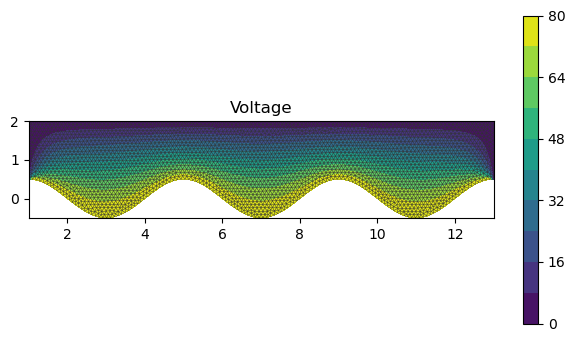

In [25]:
cfvl.figure(fig_size=(7.5, 4))
cfvl.draw_nodal_values_contourf(v, coords, edof, title="Voltage", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=True)
cfvl.colorbar()

Info    : GMSH -> Python-module
Info    : Reading '/tmp/tmpmfeahzlr/tempGeometry.geo'...
Info    : Done reading '/tmp/tmpmfeahzlr/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.00094829s, CPU 0.000772s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.18364s, CPU 0.183027s)
Info    : 6790 nodes 13543 elements
Info    : Writing '/tmp/tmpmfeahzlr/meshFile.msh'...


Info    : Done writing '/tmp/tmpmfeahzlr/meshFile.msh'
mean:  0.00060689
max:  0.00078118
[ 0.  0.  0.  0. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  

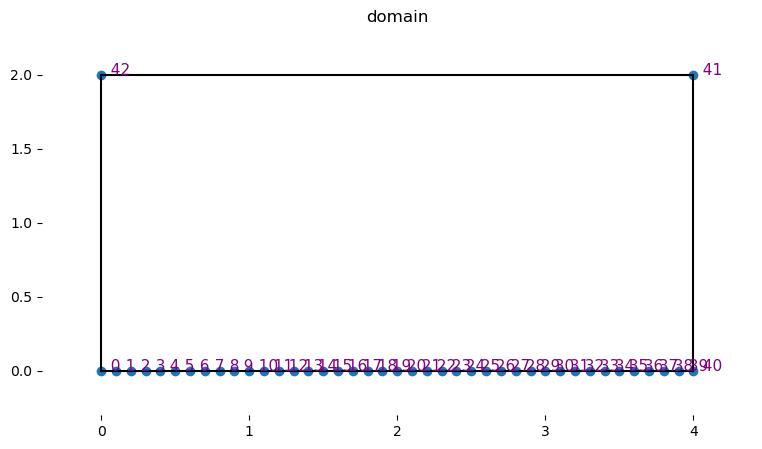

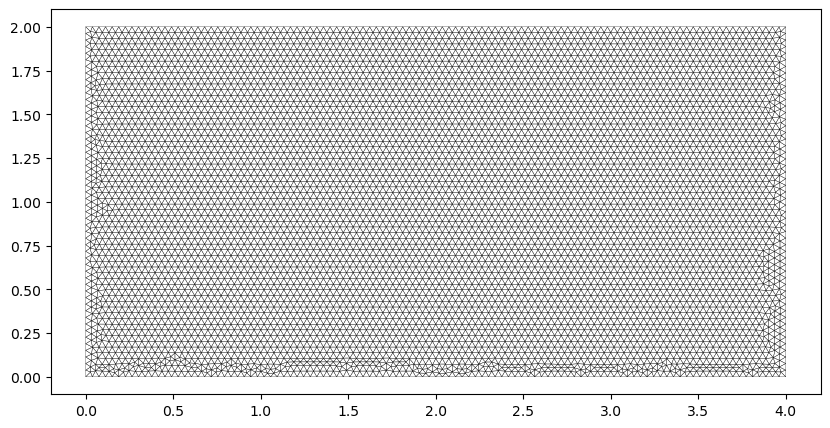

In [26]:
g = cfg.Geometry()

p_coords = []

h = 0.1
x = 0.
ind = []


while x <= 4:
    ind.append(len(p_coords))
    p_coords.append([round(x, 2), 0.])
    x = round(x + h, 2)
    # print([p_coords[-1], len(p_coords) - 1])
    g.point(p_coords[-1], len(p_coords) - 1)

g.spline(ind.copy(), 0)

# print(ind)

g.point([4., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)


g.spline([ind[-2], ind[-1]] , 1)


g.point([0., 2.], ind[-1] + 1)
ind.append(ind[-1] + 1)

g.spline([ind[-2], ind[-1]] , 2)


g.spline([ind[-1], 0] , 3)


g.surface([0, 1, 2, 3])

for curveID in [0]:
    g.curveMarker(curveID, 10)


cfvl.figure(fig_size=(10,5))
cfvl.draw_geometry(
        g,
        
        label_curves=False,
        title="domain"
)


mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.038 # Element size Factor 
"""
    mesh.elSizeFactor = 0.3325  ~   max S_el = 0.05
    mesh.elSizeFactor = 0.1425  ~   max S_el = 0.01
    mesh.elSizeFactor = 0.042   ~   max S_el = 0.001
    0.029 ~ 0.0005
"""
coords, edof, dofs, bdofs, elementmarkers = mesh.create()

print("mean: ", mean_square(coords, np.array(edof) - 1))
print("max: ", max_square(coords, np.array(edof) - 1))
boundary_voltages = reshape_boundary_dict(bdofs)

for j in range(len(boundary_voltages)):
    if boundary_voltages[j] > 10:
        boundary_voltages[j] = 10
print(boundary_voltages)

cfvl.figure(fig_size=(10,5))
cfvl.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=False,
    #title="Example 2 - Mesh"
)
#plot_fem_mesh(coords, edof)


<h3> Refactoring mesh structere for C++

In [27]:
# for i in reversed(range(44, 51)):
#     print(f"""{2.0}, {coords[i][1]}""")

for i in reversed(range(109, 161)):
    # print(f"""{round(coords[i][0],2)}, {round(coords[i][1],2)}""")
    print(f"""0.0, {(coords[i][1])}""")

# print(f"""x,y""")
# for i in coords:
#     print(f"""{i[0]}, {i[1]}""")

0.0, 1.962264150856966
0.0, 1.924528301710454
0.0, 1.886792452582558
0.0, 1.849056603446479
0.0, 1.811320754298945
0.0, 1.773584905229351
0.0, 1.735849056263062
0.0, 1.698113207167079
0.0, 1.660377357983131
0.0, 1.622641508996795
0.0, 1.584905659990719
0.0, 1.547169811047137
0.0, 1.509433962138945
0.0, 1.47169811326328
0.0, 1.433962264077287
0.0, 1.396226415135342
0.0, 1.358490566289339
0.0, 1.320754717434129
0.0, 1.283018868684374
0.0, 1.245283019748156
0.0, 1.207547170843443
0.0, 1.169811321938115
0.0, 1.132075473019081
0.0, 1.094339624070794
0.0, 1.056603775083333
0.0, 1.018867926195189
0.0, 0.9811320771839982
0.0, 0.9433962280338044
0.0, 0.9056603788919976
0.0, 0.8679245296802293
0.0, 0.8301886805558107
0.0, 0.7924528315089232
0.0, 0.7547169823392957
0.0, 0.7169811331483932
0.0, 0.6792452841137793
0.0, 0.641509434962358
0.0, 0.6037735859252895
0.0, 0.5660377367585256
0.0, 0.5283018876011722
0.0, 0.4905660383918587
0.0, 0.4528301892545525
0.0, 0.4150943401309525
0.0, 0.3773584910215

In [28]:
print(f"""p1,p2,p3""")
for i in edof:
    print(f"""{i[0]}, {i[1]}, {i[2]}""")

p1,p2,p3
401, 3911, 3966
3882, 396, 6553
340, 130, 3965
3900, 6538, 6597
3903, 414, 6548
4196, 2926, 4810
5343, 4441, 5344
6538, 420, 6597
396, 3882, 4363
272, 369, 3964
401, 3966, 6581
3884, 399, 6550
3945, 3851, 4469
3912, 404, 4355
4603, 342, 4604
4286, 3612, 5796
4306, 3606, 4321
414, 3903, 6582
3902, 352, 4383
366, 3909, 4213
3910, 369, 4382
3906, 408, 4154
3908, 416, 4191
4607, 4605, 5637
399, 3884, 6587
4441, 5343, 6583
3812, 4246, 6332
135, 331, 3944
4820, 4410, 5136
5136, 4410, 5137
3862, 4607, 5637
4343, 391, 5139
417, 144, 3926
340, 3965, 6558
342, 4603, 6586
3945, 4469, 6598
130, 131, 3965
3912, 4355, 6580
418, 3915, 3916
2926, 4196, 6555
4321, 3606, 6579
271, 272, 3964
2928, 6557, 6585
4196, 4810, 6563
3848, 3882, 6553
3964, 369, 6561
352, 3902, 6577
4482, 2925, 6540
160, 161, 4049
267, 268, 6534
5139, 391, 6591
134, 135, 3944
4286, 5796, 6572
4213, 3909, 6575
3910, 4382, 6576
3911, 401, 3967
6332, 4246, 6584
3913, 351, 4506
144, 145, 3926
408, 3906, 6574
3908, 4191, 4192


<h2> Simple FEM realization via Python tools </h2>

<text> Bad for big number of element

In [29]:
num_elem = len(edof)
num_nodes = len(dofs)

ke = np.zeros((num_elem, 3, 3))

for i in range(num_elem):
    ke[i] = Ke(coords[edof[i] - 1], 1, 1)


In [30]:
def Ke(coords, alpha_x, alpha_y):
    x1 = coords[0,0]
    x2 = coords[1,0]
    x3 = coords[2,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    y3 = coords[2,1]
    A = 1/2 * np.abs(x1*(y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2  + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix(
        [
            [M11, M12, M13],
            [M12, M22, M23],
            [M13, M23, M33]
        ])

In [31]:
K = np.zeros((num_nodes, num_nodes))
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e,i] - 1, edof[e,j] - 1] += ke[e,i,j]

In [32]:
b = np.zeros(num_nodes)

In [33]:
@njit
def bv(K, b, boundary_voltages):
    for n in (range(len(boundary_voltages))):
        for i in range(len(b)):
            if np.fabs(boundary_voltages[len(boundary_voltages) - 1 - n]) > 1e-16:
                b[i] -= boundary_voltages[len(boundary_voltages) - 1 - n]*K[i, len(boundary_voltages) - 1 - n]
        # b = np.delete(b, len(boundary_voltages) - 1 - n, axis=0)
        # K = np.delete(K, len(boundary_voltages) - 1 - n, axis=0)
        # K = np.delete(K, len(boundary_voltages) - 1 - n, axis=1)
    return K, b

In [34]:
K, b = bv(K, b, boundary_voltages)

In [35]:
for n in reversed (range(len(boundary_voltages))):
    for i in range(len(b)):
        if np.fabs(boundary_voltages[n]) > 1e-16:
            b[i] -= boundary_voltages[n]*K[i, n]
    b = np.delete(b, n, axis=0)
    K = np.delete(K, n, axis=0)
    K = np.delete(K, n, axis=1)

In [36]:
x = np.linalg.solve(K,b)
v = np.zeros(num_nodes-len(x))
v = np.concatenate((boundary_voltages,x))

Mean error:  3.5433
Max error:  9.8807 point: (2.0563, 0.0202)
L2_error S: 168.45784534
[[2.28443486 2.77257348 1.00123848 ... 1.94307266 3.84949635 3.92419573]
 [0.03186268 0.02902385 0.0317212  ... 0.02025657 0.05171717 0.05205289]]


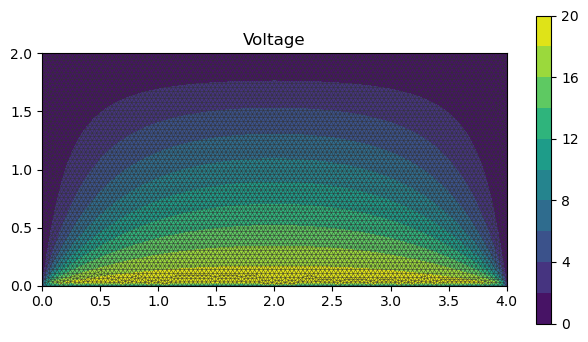

In [37]:

cfvl.figure(fig_size=(7.5, 4))

coords_with_high_err = print_error(np.array(coords).T[0], np.array(coords).T[1], v)
L2_error(np.array(coords), np.array(edof) - 1, v)
print(coords_with_high_err)

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

# plot_fem_mesh(np.array(coords).T[0], np.array(coords).T[1], np.array(edof) - 1, 0.2)
plt.scatter(coords_with_high_err[0], coords_with_high_err[1], marker="^", color="red")
# plt.axis([0, 4, 0, 2])


cfvl.draw_nodal_values_contourf(v, coords, edof, title="Voltage", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=True)

cfvl.colorbar()